# 多语言句子长度与内容相似度实验

本实验旨在探究在使用支持多语言的嵌入模型（如 BGE-M3, Jina-Embeddings-v3）时，句子长度变化（英文）以及中英文内容混合对句子向量相似度的影响。

In [73]:
# 导入所需库
import os
import numpy as np
from typing import List, Tuple, Dict
from sentence_transformers import SentenceTransformer
from openai import OpenAI # 保留以备将来使用 API
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [74]:
# 通用函数：获取嵌入 (支持本地 & API)
def get_embeddings(texts: List[str], model_name: str, use_local: bool = False) -> np.ndarray:
    if use_local:

        model = SentenceTransformer(model_name,trust_remote_code=True)
        # 本地模型支持直接归一化
        return model.encode(texts,
                            normalize_embeddings=True)
    else:
        client = OpenAI(api_key=os.getenv("API_KEY"), base_url=os.getenv("BASE_URL"))
        resp = client.embeddings.create(input=texts, model=model_name)
        emb = np.array([d.embedding for d in resp.data])
        return emb

In [75]:
# 计算余弦相似度
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [76]:
# 运行实验函数
def run_experiment(pairs: List[Tuple[str, str]], model_name: str, use_local: bool = False) -> Dict[str, float]:
    texts = [p[0] for p in pairs] + [p[1] for p in pairs]
    embeddings = get_embeddings(texts, model_name, use_local)
    n = len(pairs)
    results: Dict[str, float] = {}
    for i, (a, b) in enumerate(pairs):
        sim = cosine_similarity(embeddings[i], embeddings[i + n])
        results[f"{a} vs {b}"] = sim
    return results

In [77]:
from matplotlib.patches import Patch
import textwrap # 导入 textwrap 用于自动换行

# 可视化函数
def plot_results(results: Dict[str, float], title: str, experiment_id: int, model_nickname: str):
    """
    可视化实验结果（余弦相似度），并用颜色标示与第一个结果的差异。

    Args:
        results: 一个字典，键是比较的句子对描述（字符串），值是对应的余弦相似度（浮点数）。
        title: 图表的基础标题（字符串）。
        experiment_id: 实验编号 (整数)。
        model_nickname: 使用的模型昵称 (字符串)。
    """
    keys = list(results.keys())
    vals = list(results.values())

    if not vals: # 处理空结果的情况
        print("No results to plot.")
        return

    # 创建图表，设置更合适的画布大小
    fig, ax = plt.subplots(figsize=(12, 7)) # 稍微增加高度以容纳换行的标签

    # 定义颜色
    base_color = 'skyblue' # 更改基准颜色
    higher_color = 'lightcoral'
    lower_color = 'lightgreen'

    # 获取基准值（第一个柱子的高度）
    base_value = vals[0]

    # 绘制条形图，并根据与基准值的比较设置颜色
    colors = [base_color]
    for val in vals[1:]:
        if val > base_value:
            colors.append(higher_color)
        elif val < base_value:
            colors.append(lower_color)
        else:
            colors.append(base_color)

    bars = ax.bar(keys, vals, color=colors, width=0.5)

    # 设置更详细的图表标题
    full_title = f"实验 {experiment_id}: {title}\n(模型: {model_nickname} - 本地)"
    ax.set_title(full_title, fontsize=16, pad=20)

    # 设置Y轴范围，留出顶部空间显示数值
    ax.set_ylim(0, max(vals) * 1.2 if vals else 1.1) # 增加顶部空间
    ax.set_ylabel("余弦相似度", fontsize=12)

    # 设置X轴刻度标签，自动换行并调整旋转角度
    wrapped_labels = ['\n'.join(textwrap.wrap(key, width=30)) for key in keys] # 自动换行
    ax.set_xticks(np.arange(len(keys))) # 使用数字索引设置刻度位置
    ax.set_xticklabels(wrapped_labels, rotation=15, ha='right', fontsize=9) # 减小旋转角度

    # 添加水平网格线
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)

    # 在每个条形上方精确显示数值和内部显示与基准的差异
    for i, bar in enumerate(bars):
        y = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, y + 0.01, f"{y:.3f}",
                 ha='center', va='bottom', fontsize=9)
        if i > 0:
            diff = y - base_value
            diff_text = f"{diff:+.3f}"
            diff_color = 'red' if diff < 0 else 'green' if diff > 0 else 'gray'
            # 调整差异文本位置，避免与数值重叠
            text_y_pos = y - (max(vals) * 0.02) # 稍微向下移动一点
            ax.text(bar.get_x() + bar.get_width() / 2, text_y_pos, diff_text,
                     ha='center', va='top', fontsize=8, color=diff_color, fontweight='bold')

    # 添加图例说明颜色含义，调整位置
    legend_elements = [Patch(facecolor=base_color, edgecolor='gray', label=f'基准 ({keys[0].split(" vs ")[0][:15]}... vs ...{keys[0].split(" vs ")[1][:15]}): {vals[0]:.3f}'), # 显示部分基准标签
                       Patch(facecolor=higher_color, edgecolor='gray', label='高于基准'),
                       Patch(facecolor=lower_color, edgecolor='gray', label='低于基准')]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=9, borderaxespad=0.) # 稍微调整位置

    # 自动调整布局
    fig.tight_layout(rect=[0, 0, 0.88, 1]) # 调整布局区域，为图例留出空间

    # 显示图表
    plt.show()

In [78]:
# 定义本地模型路径 (请确保路径正确)
# 注意：Jina-v3 模型可能需要特定的加载方式或依赖，请根据实际情况调整
bge_m3_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3"
jina_v3_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3" # 假设这是 Jina v3 的路径

# 将模型路径和名称存储在字典中，方便循环调用
local_models_to_test = {
    "BGE-M3": bge_m3_model_path,
    "Jina-v3": jina_v3_model_path
}

## 实验 1: 英文句子长度变化

**目的**: 观察单边或双边增加英文句子长度（通过拼接相关英文内容）对相似度的影响。


=============== 运行实验 1 使用模型: BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  The cat sleeps on the mat. vs The feline rests upon the rug.: 0.6358
  The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace. vs The feline rests upon the rug.: 0.5227
  The cat sleeps on the mat. vs The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room.: 0.5885
  The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace. vs The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room.: 0.5892
实验结果:
  The cat sleeps on the mat. vs The feline rests upon the rug.: 0.6358
  The cat s

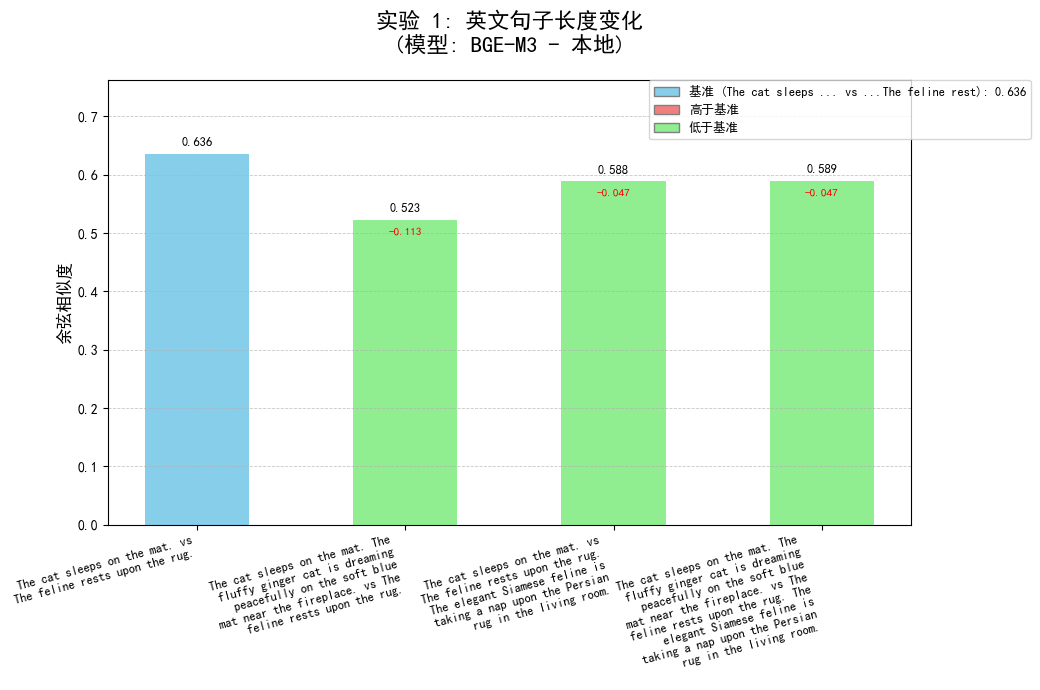


=============== 运行实验 1 使用模型: Jina-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  The cat sleeps on the mat. vs The feline rests upon the rug.: 0.7920
  The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace. vs The feline rests upon the rug.: 0.7107
  The cat sleeps on the mat. vs The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room.: 0.7855
  The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace. vs The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room.: 0.7971
实验结果:
  The cat sleeps on the mat. vs The feline rests upon the rug.: 0.792

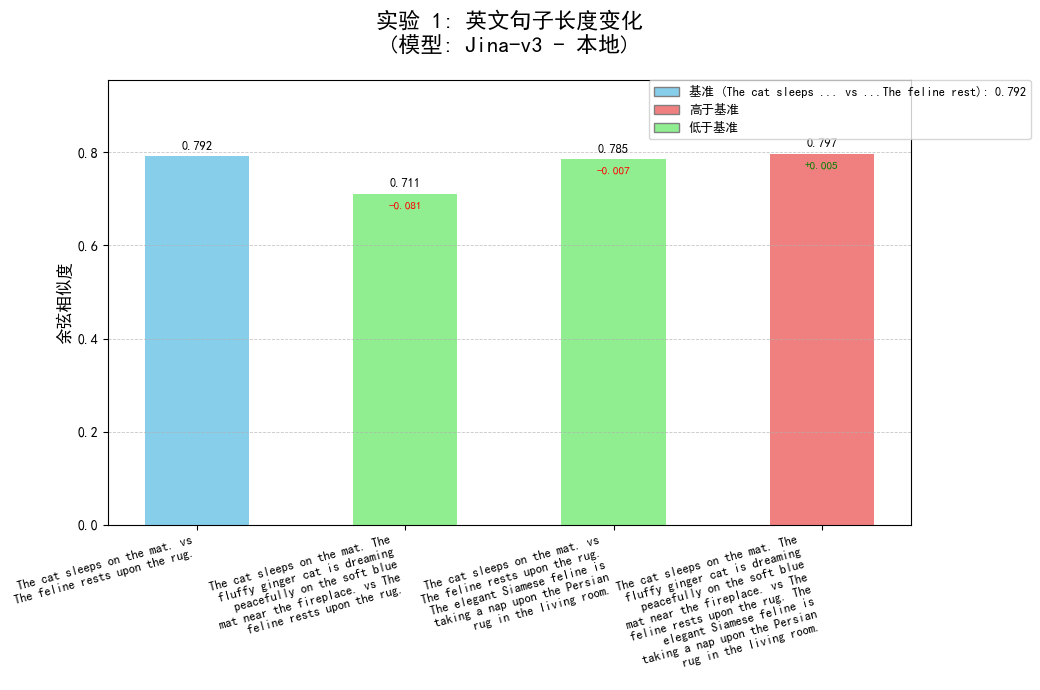

In [79]:
# 实验 1: 定义英文句子对
# s1_en_base: The cat sleeps on the mat. (猫睡在垫子上。)
s1_en_base = "The cat sleeps on the mat."
# s2_en_base: The feline rests upon the rug. (这只猫科动物在地毯上休息。)
s2_en_base = "The feline rests upon the rug."

# s1 加长 (拼接相关英文内容)
# s1_en_long: The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace.
# (猫睡在垫子上。这只毛茸茸的姜黄色猫正在壁炉旁的柔软蓝色垫子上安详地做梦。)
s1_en_long = s1_en_base + " The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace."

# s2 加长 (拼接相关英文内容)
# s2_en_long: The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room.
# (这只猫科动物在地毯上休息。这只优雅的暹罗猫正在客厅的波斯地毯上打盹。)
s2_en_long = s2_en_base + " The elegant Siamese feline is taking a nap upon the Persian rug in the living room."

pairs_exp1 = [
    (s1_en_base, s2_en_base), # 基础对
    (s1_en_long, s2_en_base), # s1 加长
    (s1_en_base, s2_en_long), # s2 加长
    (s1_en_long, s2_en_long)  # 双边加长
]

# 运行实验并可视化
experiment_counter = 1
for model_nickname, model_path in local_models_to_test.items():
    print(f"\n{'='*15} 运行实验 {experiment_counter} 使用模型: {model_nickname} ({model_path}) {'='*15}")
    print(f"--- 实验目的: {pairs_exp1.__doc__ if pairs_exp1.__doc__ else '英文句子长度变化'} ---") # 尝试获取文档字符串作为目的
    results_exp1 = run_experiment(pairs_exp1, model_name=model_path, use_local=True)
    print("实验结果:")
    for k, v in results_exp1.items():
        print(f"  {k}: {v:.4f}") # 格式化输出
    plot_results(results_exp1, "英文句子长度变化", experiment_id=experiment_counter, model_nickname=model_nickname)
experiment_counter += 1 # 移动到下一个实验编号

## 实验 2: 中英文混合拼接

**目的**: 观察在英文句子后面拼接相关的中文内容，对与另一个英文句子的相似度有何影响。


=============== 运行实验 2 使用模型: BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress.: 0.7025
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。 vs Machine learning drives AI progress.: 0.6866
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。: 0.5787
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。 vs Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。: 0.6316
实验结果:
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress.: 0.7025
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。 vs Machi

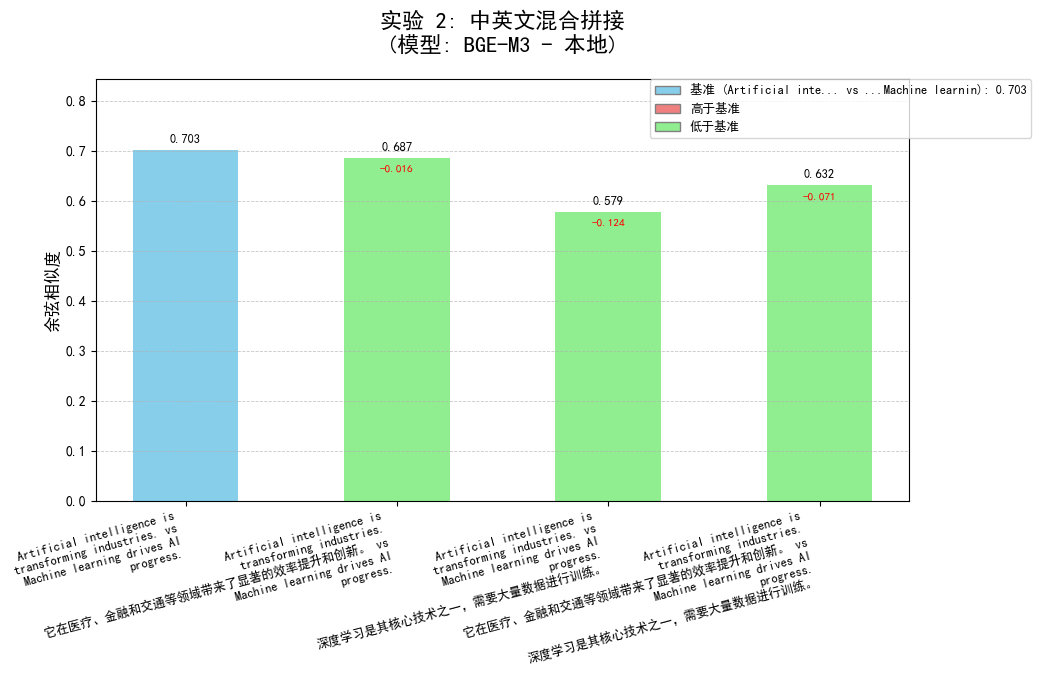


=============== 运行实验 2 使用模型: Jina-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress.: 0.7026
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。 vs Machine learning drives AI progress.: 0.6700
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。: 0.6405
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。 vs Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。: 0.6539
实验结果:
  Artificial intelligence is transforming industries. vs Machine learning drives AI progress.: 0.7026
  Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升

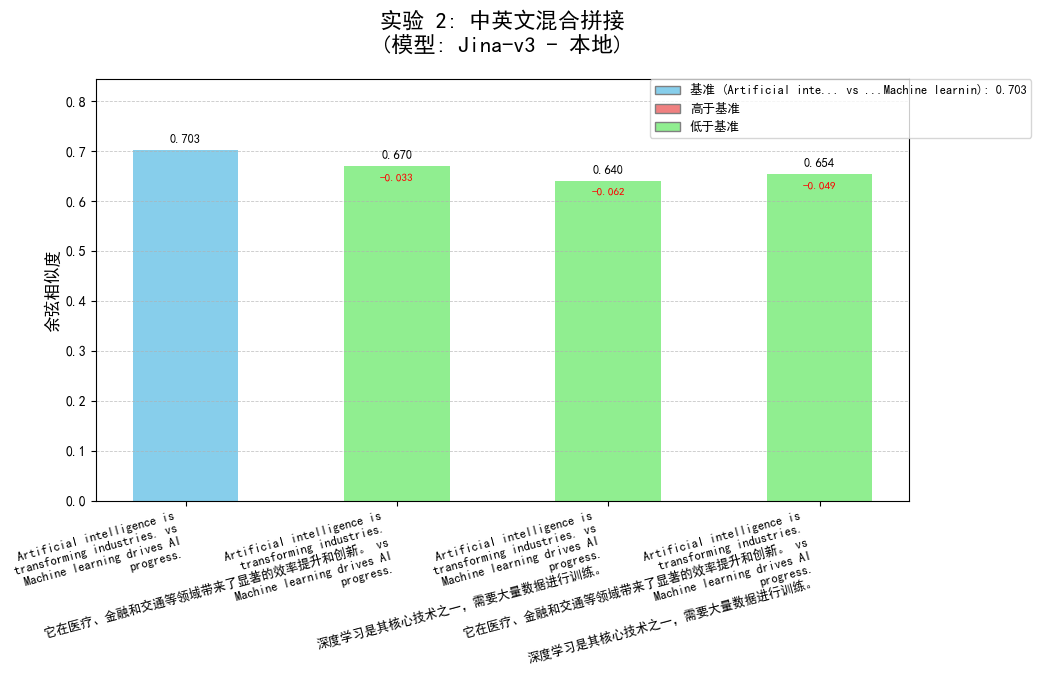

In [80]:
# 实验 2: 定义中英文混合句子对
# s3_en_base: Artificial intelligence is transforming industries. (人工智能正在改变各行各业。)
s3_en_base = "Artificial intelligence is transforming industries."
# s4_en_base: Machine learning drives AI progress. (机器学习推动人工智能发展。)
s4_en_base = "Machine learning drives AI progress."

# 中文内容 (相关)
# zh_addon_relevant: 它在医疗、金融和交通等领域带来了显著的效率提升和创新。
zh_addon_relevant = " 它在医疗、金融和交通等领域带来了显著的效率提升和创新。"
# zh_addon_ml: 深度学习是其核心技术之一，需要大量数据进行训练。
zh_addon_ml = " 深度学习是其核心技术之一，需要大量数据进行训练。"

# s3 拼接中文
s3_en_zh = s3_en_base + zh_addon_relevant
# s4 拼接中文
s4_en_zh = s4_en_base + zh_addon_ml

pairs_exp2 = [
    (s3_en_base, s4_en_base), # 基础英文对
    (s3_en_zh, s4_en_base),   # s3 拼接中文 vs s4 英文
    (s3_en_base, s4_en_zh),   # s3 英文 vs s4 拼接中文
    (s3_en_zh, s4_en_zh)      # s3 拼接中文 vs s4 拼接中文
]

# 运行实验并可视化
for model_nickname, model_path in local_models_to_test.items():
    print(f"\n{'='*15} 运行实验 {experiment_counter} 使用模型: {model_nickname} ({model_path}) {'='*15}")
    print(f"--- 实验目的: {pairs_exp2.__doc__ if pairs_exp2.__doc__ else '中英文混合拼接'} ---")
    results_exp2 = run_experiment(pairs_exp2, model_name=model_path, use_local=True)
    print("实验结果:")
    for k, v in results_exp2.items():
        print(f"  {k}: {v:.4f}")
    plot_results(results_exp2, "中英文混合拼接", experiment_id=experiment_counter, model_nickname=model_nickname)
experiment_counter += 1

## 实验 3: 关键词重叠与语言混合

**目的**: 探究在纯英文和中英混合场景下，关键词重叠对相似度的影响，以及无关内容（不同语言）的干扰。


=============== 运行实验 3 使用模型: BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  Climate change is a global challenge. vs Reducing carbon emissions is crucial.: 0.7464
  Climate change is a global challenge. vs Investing in renewable energy helps mitigate climate change.: 0.6963
  Climate change is a global challenge. vs The new movie received great reviews.: 0.5377
  Reducing carbon emissions is crucial. vs Investing in renewable energy helps mitigate climate change.: 0.6903
  Climate change is a global challenge. vs 中国经济正在快速发展。: 0.5964
  Climate change is a global challenge. 中国经济正在快速发展。 vs Reducing carbon emissions is crucial.: 0.6716
实验结果:
  Climate change is a global challenge. vs Reducing carbon emissions is crucial.: 0.7464
  Climate change is a global challenge. vs Investin

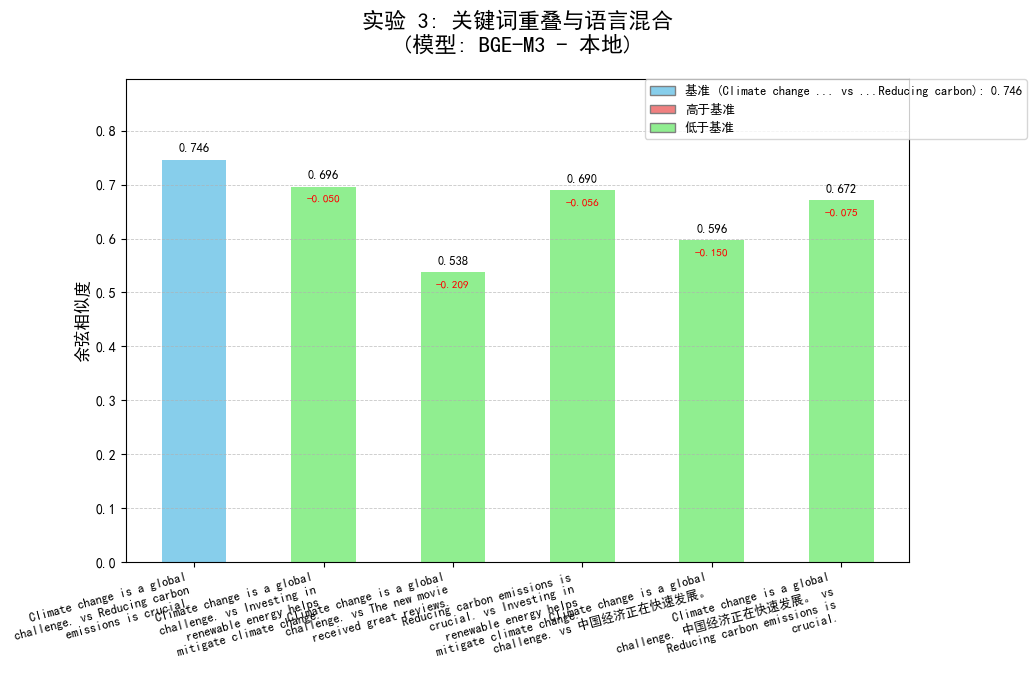


=============== 运行实验 3 使用模型: Jina-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ===============
--- 实验目的: Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified. ---
实验结果:
  Climate change is a global challenge. vs Reducing carbon emissions is crucial.: 0.7039
  Climate change is a global challenge. vs Investing in renewable energy helps mitigate climate change.: 0.7044
  Climate change is a global challenge. vs The new movie received great reviews.: 0.3757
  Reducing carbon emissions is crucial. vs Investing in renewable energy helps mitigate climate change.: 0.6997
  Climate change is a global challenge. vs 中国经济正在快速发展。: 0.4072
  Climate change is a global challenge. 中国经济正在快速发展。 vs Reducing carbon emissions is crucial.: 0.6110
实验结果:
  Climate change is a global challenge. vs Reducing carbon emissions is crucial.: 0.7039
  Climate change is a global challenge

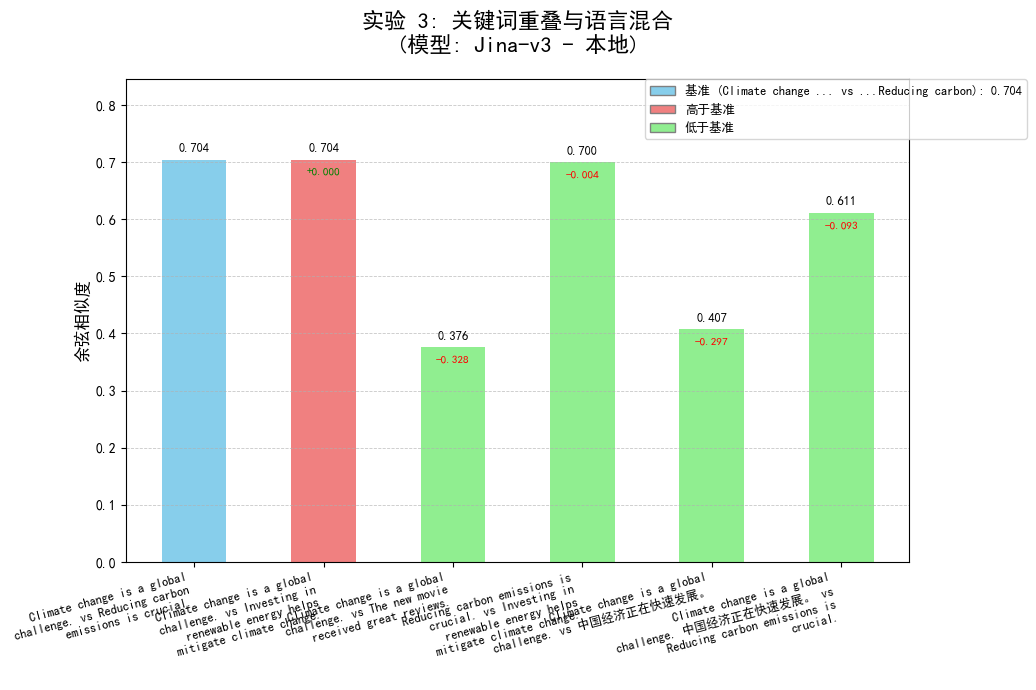

In [81]:
# 实验 3: 定义句子
# s5_en_climate: Climate change is a global challenge. (气候变化是一个全球性挑战。)
s5_en_climate = "Climate change is a global challenge."
# s6_en_carbon: Reducing carbon emissions is crucial. (减少碳排放至关重要。)
s6_en_carbon = "Reducing carbon emissions is crucial."
# s7_en_renewable: Investing in renewable energy helps mitigate climate change. (投资可再生能源有助于缓解气候变化。)
s7_en_renewable = "Investing in renewable energy helps mitigate climate change."
# s8_zh_economy: 中国经济正在快速发展。 (China's economy is developing rapidly.)
s8_zh_economy = "中国经济正在快速发展。"
# s9_en_unrelated: The new movie received great reviews. (这部新电影获得了好评。)
s9_en_unrelated = "The new movie received great reviews."

# s5 拼接无关中文
s5_en_zh_unrelated = s5_en_climate + " " + s8_zh_economy

pairs_exp3 = [
    (s5_en_climate, s6_en_carbon),       # 英文，主题相关，关键词部分重叠 (climate change, carbon)
    (s5_en_climate, s7_en_renewable),    # 英文，主题强相关，关键词重叠 (climate change)
    (s5_en_climate, s9_en_unrelated),    # 英文，主题无关，无关键词重叠
    (s6_en_carbon, s7_en_renewable),     # 英文，主题相关，关键词部分重叠 (carbon, climate change)
    (s5_en_climate, s8_zh_economy),      # 中英混合，主题无关
    (s5_en_zh_unrelated, s6_en_carbon) # s5 英文后拼接无关中文 vs s6 英文
]

# 运行实验并可视化
for model_nickname, model_path in local_models_to_test.items():
    print(f"\n{'='*15} 运行实验 {experiment_counter} 使用模型: {model_nickname} ({model_path}) {'='*15}")
    print(f"--- 实验目的: {pairs_exp3.__doc__ if pairs_exp3.__doc__ else '关键词重叠与语言混合'} ---")
    results_exp3 = run_experiment(pairs_exp3, model_name=model_path, use_local=True)
    print("实验结果:")
    for k, v in results_exp3.items():
        print(f"  {k}: {v:.4f}")
    plot_results(results_exp3, "关键词重叠与语言混合", experiment_id=experiment_counter, model_nickname=model_nickname)
experiment_counter += 1

# 实验观察与初步结论

根据上述三个实验的结果，我们可以进行一些初步的观察和总结：

**实验 1: 英文句子长度变化**

*   **观察**:
    *   当仅对一个句子进行加长（拼接相关内容）时，与原始短句的相似度通常会**下降**（例如 `"The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace." (猫睡在垫子上。这只毛茸茸的姜黄色猫正在壁炉旁的柔软蓝色垫子上安详地做梦。) vs "The feline rests upon the rug." (这只猫科动物在地毯上休息。)` 或 `"The cat sleeps on the mat." (猫睡在垫子上。) vs "The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room." (这只猫科动物在地毯上休息。这只优雅的暹罗猫正在客厅的波斯地毯上打盹。)` 相较于 `"The cat sleeps on the mat." (猫睡在垫子上。) vs "The feline rests upon the rug." (这只猫科动物在地毯上休息。)`）。这可能是因为增加的细节虽然相关，但也引入了新的信息，稀释了原始核心语义的相对权重。
    *   当两个句子都进行加长（拼接相关内容）时，相似度相较于原始短句对，其变化并不一致。
        *   **Jina-v3**: 相似度可能**略微上升**（如 `"The cat sleeps on the mat. The fluffy ginger cat is dreaming peacefully on the soft blue mat near the fireplace." (猫睡在垫子上。这只毛茸茸的姜黄色猫正在壁炉旁的柔软蓝色垫子上安详地做梦。) vs "The feline rests upon the rug. The elegant Siamese feline is taking a nap upon the Persian rug in the living room." (这只猫科动物在地毯上休息。这只优雅的暹罗猫正在客厅的波斯地毯上打盹。)`）。这表明 Jina-v3 在一定程度上能够识别两个加长句子中新增内容之间的相关性。
        *   **BGE-M3**: 相似度可能仍然**下降**，表明 BGE-M3 对长度增加带来的语义稀释更敏感，或者对新增细节间的关联性捕捉不如 Jina-v3 明显。
    *   不同模型对长度变化的敏感度确实不同。BGE-M3 似乎对单边或双边加长导致的相似度下降更为敏感，而 Jina-v3 在双边加长时表现出了一定的鲁棒性甚至微弱提升。

*   **初步结论**: 简单地增加句子长度（即使内容相关）并不一定会提高语义相似度得分，反而可能因为信息量的增加和核心语义的相对稀释而降低得分。双边加长的情况更为复杂，结果取决于新增内容的相关性以及模型的处理能力，不同模型表现不同。

**实验 2: 中英文混合拼接**

*   **观察**:
    *   在英文句子后面拼接相关的中文内容，通常会导致其与纯英文句子的相似度**下降**（例如 `"Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。" (人工智能正在改变各行各业。它在医疗、金融和交通等领域带来了显著的效率提升和创新。) vs "Machine learning drives AI progress." (机器学习推动人工智能发展。)` 或 `"Artificial intelligence is transforming industries." (人工智能正在改变各行各业。) vs "Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。" (机器学习推动人工智能发展。深度学习是其核心技术之一，需要大量数据进行训练。)` 相较于 `"Artificial intelligence is transforming industries." (人工智能正在改变各行各业。) vs "Machine learning drives AI progress." (机器学习推动人工智能发展。)`）。
    *   当两个句子都拼接了相关的中文内容后，它们之间的相似度相较于原始英文对也倾向于**下降**（例如 `"Artificial intelligence is transforming industries. 它在医疗、金融和交通等领域带来了显著的效率提升和创新。" (人工智能正在改变各行各业。它在医疗、金融和交通等领域带来了显著的效率提升和创新。) vs "Machine learning drives AI progress. 深度学习是其核心技术之一，需要大量数据进行训练。" (机器学习推动人工智能发展。深度学习是其核心技术之一，需要大量数据进行训练。)`）。
    *   **模型间比较**: 两种模型都显示出相似度下降的趋势。下降的幅度可能略有不同，但总体行为一致，表明模型虽然能理解混合语言中的语义，但语言的切换和内容的增加对相似度计算产生了显著影响。

*   **初步结论**: 多语言模型虽然能处理混合语言输入，但在计算相似度时，语言的混合（即使内容相关）似乎会引入某种“隔阂”或信息噪声，导致相似度得分普遍低于纯语言对。这提示我们在应用中需要注意跨语言/混合语言场景下相似度得分的基线可能会有所不同。

**实验 3: 关键词重叠与语言混合**

*   **观察**:
    *   在纯英文场景下，主题相关性强、关键词重叠度高的句子对（如 `"Climate change is a global challenge." (气候变化是一个全球性挑战。) vs "Investing in renewable energy helps mitigate climate change." (投资可再生能源有助于缓解气候变化。)`）通常比仅部分相关或关键词重叠较少的句子对（如 `"Climate change is a global challenge." (气候变化是一个全球性挑战。) vs "Reducing carbon emissions is crucial." (减少碳排放至关重要。)`, `"Reducing carbon emissions is crucial." (减少碳排放至关重要。) vs "Investing in renewable energy helps mitigate climate change." (投资可再生能源有助于缓解气候变化。)`）具有更高的相似度。
    *   与主题完全无关的英文句子（`"Climate change is a global challenge." (气候变化是一个全球性挑战。) vs "The new movie received great reviews." (这部新电影获得了好评。)`）相似度显著**降低**。
    *   英文句子与无关的中文句子（`"Climate change is a global challenge." (气候变化是一个全球性挑战。) vs "中国经济正在快速发展。"`）相似度同样非常**低**，表明模型能够区分不同语言且无关的内容。
    *   在一个英文句子后面拼接不相关的中文内容（`"Climate change is a global challenge. 中国经济正在快速发展。" (气候变化是一个全球性挑战。中国经济正在快速发展。)`），再与另一个相关的英文句子（`"Reducing carbon emissions is crucial." (减少碳排放至关重要。)`）比较时，其相似度相较于原始纯英文对（`"Climate change is a global challenge." (气候变化是一个全球性挑战。) vs "Reducing carbon emissions is crucial." (减少碳排放至关重要。)`）会**显著下降**。这表明无关内容的（特别是跨语言的）干扰是明显的。

*   **初步结论**:
    *   模型对于同语言内的语义相关性、关键词重叠度有较好的捕捉能力。
    *   模型能够有效区分语义无关的内容，无论是在同种语言还是不同语言之间。
    *   在句子中混入无关信息（尤其是不同语言的无关信息）会显著干扰模型对核心语义的判断，导致相似度下降。

**总体初步结论**:

1.  **长度敏感性**: 句子长度的改变会影响相似度得分，增加相关内容不一定提升相似度。
2.  **混合语言处理**: 模型能处理混合语言，但语言的切换似乎会降低相似度得分，即使内容相关。
3.  **内容相关性**: 模型对语义相关性（特别是关键词重叠）敏感，无关内容（同语言或跨语言）会显著降低相似度。
4.  **模型差异**: BGE-M3 和 Jina-v3 在具体数值和对某些变化的敏感度上可能存在差异，但总体趋势相似。

这些观察为后续更深入的分析和模型选择提供了依据。在实际应用中，需要根据具体任务场景考虑句子长度、语言纯度以及内容相关性对嵌入向量和相似度计算的影响。